In [1]:
import os
import json
import numpy as np
import pandas as pd

In [2]:
import re
import sys
import copy
import itertools
from scipy import stats

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import matplotlib.ticker as ticker

In [5]:
sys.path.append(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(os.path.join(os.getcwd(), "..", "scripts"))

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
out_path = os.path.join("..", "derivatives", "TEMP")

## Check the data used to train models

In [8]:
from data_preparing import DataManager
from feature_engineering import FeatureReducer, FeatureSelector, BorutaSelector
from age_pred_model import (
    Constants, Config, 
    convert_np_types, initialization, filter_features_preliminary, prepare_dataset, divide_and_preprocess_data
)

In [9]:
sys.argv = ['']
args, constants, config, logger = initialization()

In [10]:
print(config.raw_data_path)

/media/data2/pinwei/Age_pred_model/scripts/../data/rawdata/DATA_ses-01_2024-12-09.csv


In [11]:
raw_data = pd.read_csv(config.raw_data_path)
raw_data.shape

(423, 2050)

In [12]:
DF_prepared = prepare_dataset(args, constants, config, logger)
DF_prepared.shape

(423, 1151)

In [13]:
preprocessed_data_dicts = divide_and_preprocess_data(DF_prepared, args, config, logger)

In [14]:
ages = DF_prepared["BASIC_INFO_AGE"]
print(min(ages), max(ages))

19 80


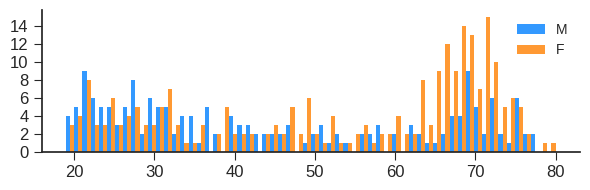

In [15]:
plt.style.use('seaborn-v0_8-ticks')
fig, ax = plt.subplots(figsize=(6, 2))
dat_1 = DF_prepared.query("BASIC_INFO_SEX == 1")["BASIC_INFO_AGE"]
dat_2 = DF_prepared.query("BASIC_INFO_SEX == 2")["BASIC_INFO_AGE"]
ax.hist(
    [dat_1, dat_2], 
    bins=np.linspace(19, 80, 61), rwidth=1, histtype='bar', 
    color=['#3399FF', '#FF9933'], # histtype='stepfilled', alpha=0.6, 
    label=[f"M", f"F"]
    # label=[f"Male (N = {len(dat_1)})", f"Female (N = {len(dat_2)})"]
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.tick_params(axis="both", which="major", labelsize=12)
ax.legend(loc=["upper left", "upper right"][1])
plt.tight_layout()
plt.savefig(os.path.join(out_path, "Age distributions.png"), dpi=500)

## Plot PAD/PADAC bars

In [16]:
from gen_derivatives import (
    Constants, Description, load_model_results, force_agesex_cols
)
from plotting import (
    plot_categorical_bars, plot_bars_with_stats, plot_cormat, plot_color_legend
)
from compare_versions import (
    Config, define_arguments, compare_pad_values
)

In [17]:
sys.argv = [
    'compare_versions.py', 
    '-v', '0', 
    '-ba', '2025-09-17_original_sex-0_XGBM', 
    '-un', '2025-09-17_original_age-0_sex-0_XGBM', 
    '-n', 'Original data (testing set), XGBM model, no feature selection or reduction', 
    '-p', 'original_XGBM', 
    '-cbg', '0'
]

In [18]:
args = define_arguments()
custom_bar_x_lab = ["AgeGroup", "AgeSex"][args.custom_bar_x_lab] if args.custom_bar_x_lab is not None else None
const = Constants()
config = Config(args)

In [19]:
version_list = list(config.input_folders.keys())
color_dict = dict(zip(version_list, sns.color_palette("husl", len(version_list))))

In [20]:
result_DF_list = []
args.ignore_all = False

for version, input_folder in config.input_folders.items():
    desc_json_path = os.path.join(input_folder, "description.json")
    with open(desc_json_path, 'r', errors='ignore') as f:
        desc_json = json.load(f)
    desc = Description(desc_json, const, args)

    config.result_path = os.path.join(input_folder, "results_{}_{}.json")
    result_DF, _, _ = load_model_results(
        config, desc, const, 
        output_path=os.path.join(out_path, f"results_DF_{version}.csv"), 
        overwrite=args.overwrite
    )
    result_DF["Version"] = version
    result_DF["VerType"] = result_DF["Version"] + "_" + result_DF["Type"]

    result_DF.rename(columns={"PredictedAgeDifference": "PAD", "CorrectedPAD": "PADAC",}, inplace=True)
    result_DF["PAD_abs"] = result_DF["PAD"].abs()
    result_DF["PADAC_abs"] = result_DF["PADAC"].abs()

    if args.custom_bar_x_lab is not None:
        data_DF = pd.read_csv(config.raw_data_path)
        data_DF["SID"] = data_DF["BASIC_INFO_ID"].map(lambda x: x.replace("sub-0", ""))
        temp_DF = force_agesex_cols(DF=result_DF, DF2=data_DF)
        temp_DF.rename(columns={custom_bar_x_lab: "BarGroup"}, inplace=True)
        result_DF = pd.merge(
            result_DF, temp_DF.loc[:, ["SID", "BarGroup"]], on="SID", how="left"
        )
            
    if "Sex" not in result_DF.columns:
        result_DF["Sex"] = ""
        result_DF.replace({"AgeGroup": {"le-44": "Y", "ge-45": "O"}}, inplace=True)
        result_DF.replace({"BarGroup": {"le-44": "Y", "ge-45": "O"}}, inplace=True)
    else:
        result_DF.replace({"AgeGroup": {"all": "", "le-44": "Y", "ge-45": "O"}}, inplace=True)
        result_DF.replace({"BarGroup": {"all": "", "le-44": "Y", "ge-45": "O"}}, inplace=True)
    
    result_DF["Group"] = result_DF["AgeGroup"] + result_DF["Sex"]
    result_DF_list.append(result_DF)

final_result_DF = pd.concat(result_DF_list, ignore_index=True)
final_result_DF.drop_duplicates(inplace=True)

Loading results_le-44_STRUCTURE.json ...
Loading results_le-44_BEH.json ...
Loading results_le-44_FUNCTIONAL.json ...
Loading results_le-44_ALL.json ...
Loading results_ge-45_STRUCTURE.json ...
Loading results_ge-45_BEH.json ...
Loading results_ge-45_FUNCTIONAL.json ...
Loading results_ge-45_ALL.json ...
Loading results_all_STRUCTURE.json ...
Loading results_all_BEH.json ...
Loading results_all_FUNCTIONAL.json ...
Loading results_all_ALL.json ...


In [21]:
# final_result_DF.head()

In [ ]:
stats_DF_dict = {}
feature_orientations = final_result_DF["Type"].unique()

for pad_type in ["PAD", "PADAC"]:
    stats_DF_list = []
    
    for ori_name in feature_orientations:
        for group in ["Y", "O"]:
            for ver_1, ver_2 in itertools.combinations(version_list, 2):
                stats_results = compare_pad_values(
                    V1_abs=final_result_DF.query(
                        f"Type == '{ori_name}' & BarGroup == '{group}' & Version == '{ver_1}'"
                    )[f"{pad_type}_abs"], 
                    V2_abs=final_result_DF.query(
                        f"Type == '{ori_name}' & BarGroup == '{group}' & Version == '{ver_2}'"
                    )[f"{pad_type}_abs"], 
                    independent=True if args.different_participants else False
                )
                stats_results.insert(0, "Type", ori_name)
                stats_results.insert(1, "Group", group)
                stats_results.insert(2, "V1", ver_1)
                stats_results.insert(3, "V2", ver_2)
                stats_DF_list.append(stats_results)
    
    stats_DF = pd.concat(stats_DF_list, ignore_index=True)
    stats_DF_dict[pad_type] = stats_DF

In [38]:
for pad_type in ["PAD", "PADAC"]:
    sns.set_style("whitegrid", {'grid.linestyle': '--'})
    color_dict = dict(zip(["Y", "O"], sns.color_palette("Set2", 2)))
    
    g = sns.catplot(
        data=final_result_DF, 
        x="Version", y=f"{pad_type}_abs", kind="bar", errorbar="se", sharex=False, 
        col="Type", hue="BarGroup", palette=color_dict, 
        height=5, aspect=.6, alpha=.8, legend=None
    )
    
    for col_val, ax in g.axes_dict.items():
        sub_stats_DF = stats_DF_dict[pad_type].query(f"Type == '{col_val}'")
        y_pos = max([sub_stats_DF["V1_mean"].max(), sub_stats_DF["V2_mean"].max()])
        
        for group, x_pos in zip(["Y", "O"], [-.2, .2]):
            stats_res = sub_stats_DF.query(f"Group == '{group}'")
            p_val = stats_res.iloc[0]["P_value"]
            p_sig = stats_res.iloc[0]["P_sig"]
            # p_sig = "< .001 ***" if p_val < .001 else f"{p_val:.3f} {p_sig}"
            
            if p_val < .05:
                y_pos += 2.5 # offset
                ax.plot( 
                    [x_pos, x_pos+1], [y_pos, y_pos], color="k", lw=1.5
                )
                ax.text(
                    (x_pos+.5), y_pos, p_sig, ha="center", va="bottom", fontsize=20, fontdict={"style": "italic"}
                )
        ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        ax.set_title(col_val, fontsize=20)
        ax.tick_params(axis="both", which="major", labelsize=18)
        
    g.set(ylim=(0, 20))
    g.figure.tight_layout()
    g.set_xlabels("")
    g.set_ylabels("")
    g.figure.savefig(os.path.join(out_path, f"2025-10-23 compare_{pad_type}_bars.png"))
    plt.close()

In [41]:
temp_result_DF = (
    final_result_DF
    .loc[:, ["Version", "Type", "BarGroup", "SID", "PAD_abs", "PADAC_abs"]]
    .melt(id_vars=["Version", "Type", "BarGroup", "SID"], 
          value_vars=["PAD_abs", "PADAC_abs"], 
          var_name="var")
)
temp_result_DF["NewGroup"] = temp_result_DF["BarGroup"].astype(str) + "_" + temp_result_DF["var"]

In [43]:
temp_stats_DF_1 = stats_DF_dict["PAD"].copy(deep=True)
temp_stats_DF_1.insert(0, "var", "PAD")
temp_stats_DF_2 = stats_DF_dict["PADAC"].copy(deep=True)
temp_stats_DF_2.insert(0, "var", "PADAC")
temp_stats_DF = pd.concat(
    [temp_stats_DF_1, temp_stats_DF_2], 
    ignore_index=True
)
temp_stats_DF["NewGroup"] = temp_stats_DF["Group"] + "_" + temp_stats_DF["var"]

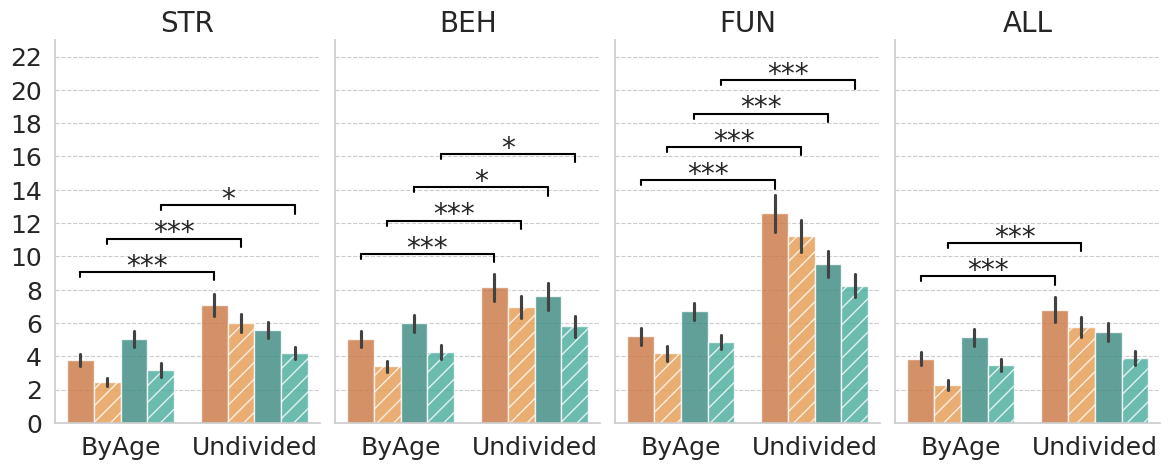

In [70]:
color_list = ["#E1712B", "#FE9A37", "#2A9689", "#36BBA7"]
hatches = itertools.cycle(['', '//'])

g = sns.catplot(
    data=temp_result_DF, 
    x="Version", y="value", col="Type", kind="bar", errorbar="se", sharex=False, 
    hue="NewGroup", hue_order=["Y_PAD_abs", "Y_PADAC_abs", "O_PAD_abs", "O_PADAC_abs"], palette=color_list, 
    height=5, aspect=.6, alpha=.8, legend=None
)

for col_val, ax in g.axes_dict.items():
    sub_stats_DF = temp_stats_DF.query(f"Type == '{col_val}'")
    y_pos = max([sub_stats_DF["V1_mean"].max(), sub_stats_DF["V2_mean"].max()])
    
    for group, x_pos in zip(["Y_PAD", "Y_PADAC", "O_PAD", "O_PADAC"], np.linspace(-.3, .3, 4)):
        stats_res = sub_stats_DF.query(f"NewGroup == '{group}'")
        p_val = stats_res.iloc[0]["P_value"]
        p_sig = stats_res.iloc[0]["P_sig"]
        
        if p_val < .05:
            y_pos += 2 # offset
            ax.plot( [x_pos, x_pos+1], [y_pos, y_pos], color="k", lw=1.5)
            ax.plot( [x_pos, x_pos], [y_pos, y_pos-.3], color="k", lw=1.5)
            ax.plot( [x_pos+1, x_pos+1], [y_pos, y_pos-.5], color="k", lw=1.5)
            ax.text((x_pos+.5), y_pos-.5, p_sig, 
                    ha="center", va="bottom", fontsize=20, fontdict={"style": "italic"})
            
    for i, bar in enumerate(ax.patches):
        if i % 2 == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.set_title(col_val, fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=18)
    
g.set(ylim=(0, 23))
g.figure.tight_layout()
g.set_xlabels("")
g.set_ylabels("")
g.figure.savefig(os.path.join(out_path, f"2025-10-24 compare_PAD+PADAC_bars.png"))

In [98]:
final_result_DF.head(1)

,Type,SID,Model,AgeGroup,Age,PredictedAge,PAD,PADAC,CorrectedPredictedAge,NumberOfFeatures,Version,VerType,PAD_abs,PADAC_abs,BarGroup,Sex,Group
0,STR,001,XGBM,Y,41,32.448372,-8.551628,-6.479589,34.520411,680,ByAge,ByAge_STR,8.551628,6.479589,Y,,Y


In [100]:
stats_DF_list = []

for version in ["ByAge", "Undivided"]:
    for group in ["Y", "O"]:
        for pad_type in ["PAD", "PADAC"]:
            for ori_1, ori_2 in itertools.combinations(feature_orientations, 2):
                stats_results = compare_pad_values(
                    V1_abs=final_result_DF.query(
                        f"Version == '{version}' & BarGroup == '{group}' & Type == '{ori_1}'"
                    )[f"{pad_type}_abs"], 
                    V2_abs=final_result_DF.query(
                        f"Version == '{version}' & BarGroup == '{group}' & Type == '{ori_2}'"
                    )[f"{pad_type}_abs"], 
                    independent=True if args.different_participants else False
                )
                stats_results.insert(0, "Version", version)
                stats_results.insert(1, "Group", group)
                stats_results.insert(1, "PAD_type", pad_type)
                stats_results.insert(3, "V1", ori_1)
                stats_results.insert(4, "V2", ori_2)
                stats_DF_list.append(stats_results)
                
new_stats_DF = pd.concat(stats_DF_list, ignore_index=True)

In [81]:
temp_result_DF["NewGroup2"] = temp_result_DF["Version"] + "_" + temp_result_DF["BarGroup"].astype(str)
temp_result_DF["var"] = temp_result_DF["var"].map({"PAD_abs": "original", "PADAC_abs": "corrected"})

In [105]:
x_pos_dict = {
    "PAD": dict(zip(feature_orientations, np.linspace(-.3, .3, 4))), 
    "PADAC": dict(zip(feature_orientations, np.linspace(-.3, .3, 4) + 1))
}

In [110]:
np.linspace(-.3, .3, 4) + 1

array([0.7, 0.9, 1.1, 1.3])

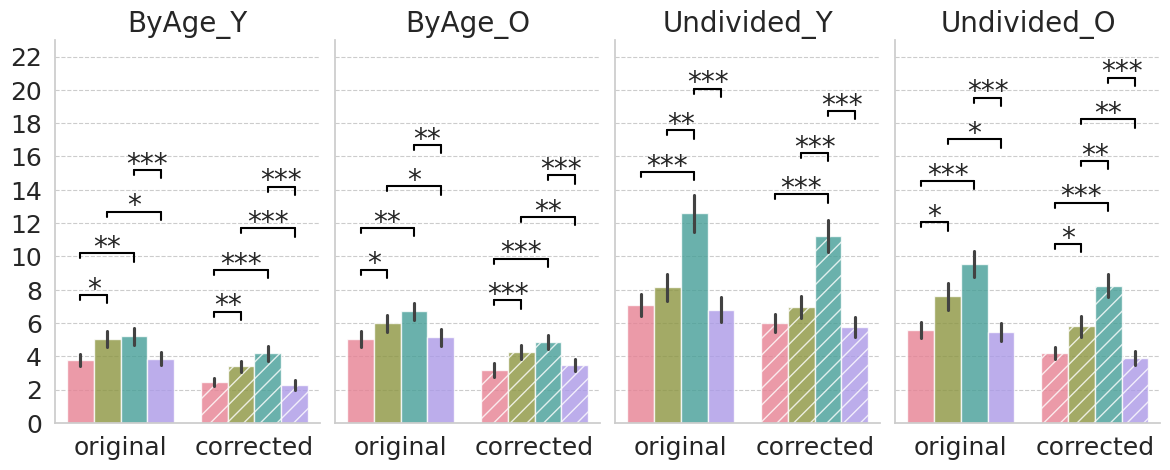

In [119]:
g = sns.catplot(
    data=temp_result_DF, 
    x="var", y="value", col="NewGroup2", kind="bar", errorbar="se", sharex=False, 
    hue="Type", hue_order=["STR", "BEH", "FUN", "ALL"], palette=sns.color_palette("husl", 4), 
    height=5, aspect=.6, alpha=.8, legend=None
)

for col_val, ax in g.axes_dict.items():
    version, group = col_val.split("_")

    for pad_type in ["PAD", "PADAC"]: 
        sub_stats_DF = new_stats_DF.query(f"Version == '{version}' & Group == '{group}' & PAD_type == '{pad_type}'")
        y_pos = max([sub_stats_DF["V1_mean"].max(), sub_stats_DF["V2_mean"].max()])

        for ori_1, ori_2 in itertools.combinations(feature_orientations, 2):
            stats_res = sub_stats_DF.query(f"V1 == '{ori_1}' & V2 == '{ori_2}'")
            p_val = stats_res.iloc[0]["P_value"]
            p_sig = stats_res.iloc[0]["P_sig"]
            
            if p_val < .05:
                x_pos_1 = x_pos_dict[pad_type][ori_1]
                x_pos_2 = x_pos_dict[pad_type][ori_2]
                y_pos += 2.5 # offset
                ax.plot( [x_pos_1, x_pos_2], [y_pos, y_pos], color="k", lw=1.5)
                ax.plot( [x_pos_1, x_pos_1], [y_pos, y_pos-.3], color="k", lw=1.5)
                ax.plot( [x_pos_2, x_pos_2], [y_pos, y_pos-.5], color="k", lw=1.5)
                ax.text(np.mean([x_pos_1, x_pos_2]), y_pos-.5, p_sig, 
                        ha="center", va="bottom", fontsize=20, fontdict={"style": "italic"})

    for i, bar in enumerate(ax.patches):
        if i % 2 == 1:
            bar.set_hatch('//')
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.set_title(col_val, fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=18)
    
g.set(ylim=(0, 23))
g.figure.tight_layout()
g.set_xlabels("")
g.set_ylabels("")
g.figure.savefig(os.path.join(out_path, f"2025-10-24 compare_PAD+PADAC_bars (2).png"))

## Plot feature sunbursts 

In [25]:
from gen_derivatives import make_feature_DF, ColorDicts
from plotting import plot_feature_sunburst

In [26]:
color_dicts = ColorDicts()

In [27]:
domain_approach_mapping = { 
    "STRUCTURE": {
        "domains": ["STRUCTURE"],
        "approaches": ["MRI"]
    },
    "BEH": {
        "domains": ["MOTOR", "MEMORY", "LANGUAGE"],
        "approaches": ["BEH"]
    },
    "FUNCTIONAL": {
        "domains": ["MOTOR", "MEMORY", "LANGUAGE"],
        "approaches": ["EEG", "MRI"]
    }, 
    "ALL": {
        "domains": ["STRUCTURE", "MOTOR", "MEMORY", "LANGUAGE"], 
        "approaches": ["MRI", "BEH", "EEG"]
    }
}

In [28]:
for ori_name, ori_content in domain_approach_mapping.items():
    
    DF_filtered = filter_features_preliminary(
        DF_prepared, 
        domains=ori_content["domains"], 
        approaches=ori_content["approaches"] , 
        ori_name=ori_name
    )
    feature_list = DF_filtered.columns
    feature_DF = make_feature_DF(ori_name, feature_list, None)
    
    plot_feature_sunburst(
        feature_DF_dict=feature_DF, 
        parent_col="approach_and_num", 
        label_col="domain_and_num", 
        color_dict=color_dicts.sunburst[ori_name], 
        one_or_many="one", 
        fig_title=ori_name[:3], 
        output_path=os.path.join(out_path, f"2025-10-23 feature_sunburst ({ori_name[:3]}).png"), 
        overwrite=True
    )


Sunburst plot is saved to:
../derivatives/TEMP/2025-10-23 feature_sunburst (STR).png

Sunburst plot is saved to:
../derivatives/TEMP/2025-10-23 feature_sunburst (BEH).png

Sunburst plot is saved to:
../derivatives/TEMP/2025-10-23 feature_sunburst (FUN).png

Sunburst plot is saved to:
../derivatives/TEMP/2025-10-23 feature_sunburst (ALL).png
